**Submission Instruction**

1- Copy the notebook and replace blank with your name

2- Complete the notebook

3- Run all of the cells (all cells must have output)

4- Downlow the .ipynb (file->Download->Download .ipynb)

5- Submit on the .ipynb on Gradescope

Note: Make sure that you submitted the correct file and check your submission to have the outputs.


# N-gram Language Models Project

In this project, you'll build and test N-gram language models - the simplest type of language model that predicts the next word based only on the previous N words.

## What you'll learn:
* Train unigram and N-gram models on text data
* Measure model quality using perplexity scores
* Generate new text from your trained models
* Apply Laplace smoothing to handle unseen word combinations


## Dataset:
Shakespeare's plays

## Key concept:
N-gram models assume that predicting a word only depends on the N words that came before it, making them simple but effective for understanding language modeling basics.

## RUBRIC (Total: 40 points)

### **Section 1: Unigram Language Models (10 points)**

- **append_eos function**  
  - Correctly appends `<eos>` to each sentence.  
  - Passes `test_append_eos()`.

- **compute_unigram_probabilities function**  
  - Correctly computes unigram probabilities.  
  - Passes `validate_unigram()` test cases.

- **eval_likelihood_word_unigram function**  
  - Computes average log likelihood and perplexity for unigram model.  
  - Handles unknown words with `(-inf, inf)`.  
  - Handles numerical issues appropriately.

- **switch_with_unk function**  
  - Replaces rare words with `<unk>` based on threshold.  
  - Passes `test_wth_unks()` for thresholds 3 and 5.

- **eval_likelihood_word_unigram_unk function**  
  - Evaluates likelihood/perplexity using `<unk>` for unseen words.  
  - Produces finite perplexity on dev set.

- **generate_unigram_sample function**  
  - Samples words from unigram distribution, respects prefix, stops at `<eos>` or `max_words`.  
  - Passes `test_sampling()`.

---

### **Section 2: N-gram Language Models (10 points)**

- **process_Ngram function**  
  - Adds correct number of `<sos>` tokens based on N.  
  - Passes `test_process_text_for_Ngram()` for N = 1 to 4.

- **NGramLM class – fit method**  
  - Processes data, builds vocab (including `<unk>`), counts n-grams and contexts.

- **NGramLM class – evaluate method**  
  - Computes perplexity on eval data.  
  - Maps unseen words to `<unk>`.  
  - Returns `inf` for zero-probability events.  
  - Matches unigram sanity check.  
  - Achieves expected perplexities for bigram/trigram.

- **NGramLM class – sampling method**  
  - Samples text from model using prefix.  
  - Uses `np.random.choice`.  
  - Terminates on `<eos>` or `max_words`.  
  - Passes `test_sample_text_ngram()`.

---

### **Section 3: Add-k Smoothing (10 points)**

- **Ksmoothing class – fit method**  
  - Inherits from NGramLM.  
  - Correctly sets vocabulary size `V`.

- **Ksmoothing class – eval_perplexity method**  
  - Computes smoothed probabilities.  
  - Produces finite dev perplexity.  
  - Meets expected perplexity thresholds (≤ 61 train, ≤ 149 dev for bigram with k=0.01).

- **Ksmoothing class – sample_text method**  
  - Samples using smoothed probabilities.  
  - Includes all vocab words as possible next tokens.  
  - Passes `test_sample_text_bigram_laplace_model()` and `test_sample_text_ngram_laplace()`.

---




Place the data files from the BB on your Google drive

### Dataset loading instruction:
The data is taken from Shakespear Plays data.
The data file consists of two files train.txt and dev.text.

1. Mount the google drive- ensures you can access your files in Google Drive from Colab.
2. Make sure your path points to the folder where train.txt and dev.txt are located.
3. Read both training and dev data as line-separated sentences.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#change the path address if to be consistent with your address
path = '/content/drive/My Drive/ngram/'


Mounted at /content/drive


In [ ]:
#you can check the files in the path
!ls "{path}"

dev.txt  train.txt


In [ ]:
# Load necessary packages
import os
from typing import List, Dict,Tuple

import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict,Counter

# Setup nltk
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:

# Helper functions for test cases
def evaluate_test_case(input, output, expected_output, output_str="Output", atol=1e-4):
    """
    Evaluate a test case by comparing actual output with expected output.

    Args:
        input: The test input (can be None)
        output: The actual output from your code
        expected_output: What the output should be
        output_str: Label for the output (defaults to "Output")
        atol: Absolute tolerance for numerical comparisons (defaults to 1e-4)
    """

    # Display input if provided
    if input is not None:
        print("Input:\n", input)

    # Display outputs
    print(f"{output_str}:\n", output)
    print(f"Expected {output_str}:\n", expected_output)

    # Determine comparison method based on type
    if isinstance(output, str):
        match = output == expected_output
    elif isinstance(output, list):
        match = output == expected_output
    else:
        # For numerical data (arrays, numbers, etc.)
        try:
            match = np.allclose(output, expected_output, atol=atol)
        except:
            # Fallback to regular equality if np.allclose fails
            match = output == expected_output

    # Report result
    if match:
        print("Test case passed! :)")
    else:
        print("Test case failed! :(")

    print("\n" + "="*50 + "\n")

    return match  # Return boolean result in case you need it

## Section 1: Word-level Unigram Language Models

We'll start with the simplest type of language model: **unigram models**. These models treat each word independently and learn how often each word appears in the training data.

### Key Concept:
For a sequence of words $w_1, w_2, \cdots, w_n$, a unigram model calculates the probability as:

$$P(w_1, w_2, \cdots, w_n) = P(w_1) \times P(w_2) \times \cdots \times P(w_n)$$

where $P(w_i)$ is simply how frequently word $w_i$ appears in the training corpus.

### What you'll do:
* Learn word frequencies from Shakespeare's plays
* Calculate probabilities for individual words
* Understand how independence assumption works in practice



In [ ]:
with open(f"{path}/train.txt") as f:
    train_data = f.read().split("\n")

with open(f"{path}/dev.txt") as f:
    dev_data = f.read().split("\n")

print first 10 sentences from the training data.

In [ ]:
print("\n".join(train_data[:10]))

First Citizen : Before we proceed any further , hear me speak .
All : Speak , speak .
First Citizen : You are all resolved rather to die than to famish ?
All : Resolved .
resolved .
First Citizen : First , you know Caius Marcius is chief enemy to the people .
All : We know't , we know't .
First Citizen : Let us kill him , and we 'll have corn at our own price .
Is't a verdict ?
All : No more talking o n't ; let it be done : away , away !


Preprocessing- put an **\<eos\>** tag at the end of each sentence in the training and dev sets


In [ ]:
#TO-FILL section
def append_eos(lines: List[str]) -> List[str]:
    """
    Appends the <eos> (end-of-sequence) token to each line of text.

    Parameters:
    - lines (List[str]): A list of strings, where each string represents a line of text.

    Returns:
    - List[str]: A new list where each string has the <eos> token appended at the end.
    """
    return [line + " <eos>" for line in lines]

In [ ]:
def test_append_eos():
    print("Running Sample Test Case 1")
    data = ["hello!", "world!"]

    evaluate_test_case(data, append_eos(data), ["hello! <eos>", "world! <eos>"])



test_append_eos()

Running Sample Test Case 1
Input:
 ['hello!', 'world!']
Output:
 ['hello! <eos>', 'world! <eos>']
Expected Output:
 ['hello! <eos>', 'world! <eos>']
Test case passed! :)




In [ ]:
train_data_processed = append_eos(train_data)
dev_data_processed = append_eos(dev_data)

## Section 1.1: Unigram Language Model

It estimates the probability of each word based solely on its frequency in the training corpus.$$p(w_i) = \frac{C(w_i)}{n}$$

where $C(w_i)$ is the count of word $w_i$ in the training data and $n$ is the total number of words in the training dataset.

In [ ]:
#TO-FILL section
def compute_unigram_probabilities(sentences: List[str]) -> Dict[str, float]:
    """
    Compute word-level unigram probabilities from a list of sentences.

    Parameters

    - sentences : List[str] A list of sentences from the training corpus.

    Returns

    - Dict[str, float] A dictionary mapping each unique word to its unigram probability,calculated as the frequency of the word divided by the total number of words.
    """
    unigram_probs = {}
    word_counts = Counter()
    total_words = 0

    for sentence in sentences:
        words = sentence.split()
        for word in words:
            word_counts[word] += 1
            total_words += 1

    for word, count in word_counts.items():
        unigram_probs[word] = count / total_words

    return unigram_probs

In [ ]:
def validate_unigram(unigram_probs):

    print("Running Sample Test Case 1: Check if the number of unique words is correct")
    evaluate_test_case(None, len(unigram_probs), 12610, output_str="Number of unique words")

    print("Running Sample Test Case 2: Check if the probability of word \"thou\" is correct")
    evaluate_test_case("thou", unigram_probs["thou"], 0.004559649641510829)

    print("Running Sample Test Case 3: Check if the probability of word \"love\" is correct")
    evaluate_test_case("love", unigram_probs["love"], 0.0015984182127282134)

    print("Running Sample Test Case 4: Check if the probability of word \"Richard\" is correct")
    evaluate_test_case("Richard", unigram_probs["Richard"], 0.0005035479340675586)

    print("Running Sample Test Case 5: Check if the probability of word \"pytorch\" is correct")
    evaluate_test_case("pytorch", unigram_probs.get("pytorch", 0), 0)

    print("Running Sample Test Case 6: Check if the probability of word \"richard\" is correct")
    evaluate_test_case("richard", unigram_probs.get("richard", 0), 0)




In [ ]:
def plot_unigram_distribution(unigram_probs: Dict[str, float], top_k: int = 50):
    """
    Visualizes the unigram probability distribution as a bar chart.

    Parameters
    - unigram_probs : Dict[str, float] Dictionary mapping words to their unigram probabilities.

    - top_k : int Number of top most frequent words to show in the plot.
    """

    sorted_items = sorted(unigram_probs.items(), key=lambda x: x[1], reverse=True)
    top_items = sorted_items[:top_k]

    words = [word for word, _ in top_items]
    probs = np.array([p for _, p in top_items])


    x = np.linspace(0, len(probs) - 1, 500)
    smooth_probs = np.interp(x, np.arange(len(probs)), probs)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(x, smooth_probs, label='PDF-like Curve')
    plt.scatter(range(len(probs)), probs, color='red', s=10, label='Original Points')

    # Optional: word labels
    plt.xticks(ticks=np.arange(len(words)), labels=words, rotation=90)

    plt.title('Unigram Probability Distribution (Top {} Words)'.format(top_k))
    plt.xlabel('Words (by rank)')
    plt.ylabel('Probability')

    plt.tight_layout()
    plt.grid(True)
    plt.show()




Running Sample Test Case 1: Check if the number of unique words is correct
Number of unique words:
 12610
Expected Number of unique words:
 12610
Test case passed! :)


Running Sample Test Case 2: Check if the probability of word "thou" is correct
Input:
 thou
Output:
 0.004559649641510829
Expected Output:
 0.004559649641510829
Test case passed! :)


Running Sample Test Case 3: Check if the probability of word "love" is correct
Input:
 love
Output:
 0.0015984182127282134
Expected Output:
 0.0015984182127282134
Test case passed! :)


Running Sample Test Case 4: Check if the probability of word "Richard" is correct
Input:
 Richard
Output:
 0.0005035479340675586
Expected Output:
 0.0005035479340675586
Test case passed! :)


Running Sample Test Case 5: Check if the probability of word "pytorch" is correct
Input:
 pytorch
Output:
 0
Expected Output:
 0
Test case passed! :)


Running Sample Test Case 6: Check if the probability of word "richard" is correct
Input:
 richard
Output:
 0
Expected

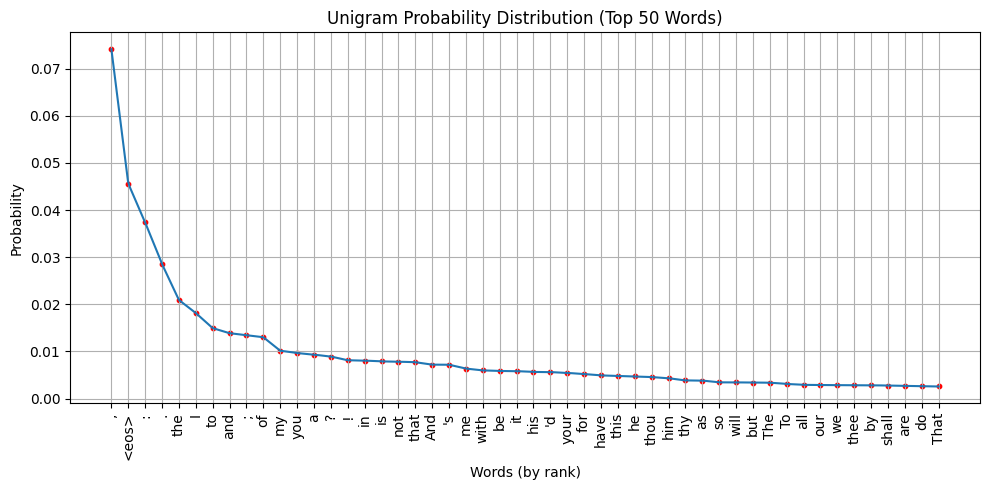

In [ ]:
unigram_probs = compute_unigram_probabilities(train_data_processed)
validate_unigram(unigram_probs)
plot_unigram_distribution(unigram_probs , top_k=50)

### Section 1.2: Evaluating (word-level) Unigram Language Models .
Probability of a sentence is computed by multiplying the probabilities of individual words, assuming independence between them. The log-likelihood is simply the **log of that probability**, which avoids numerical underflow and allows us to **add** rather than multiply probabilities:

$$
\log P(w_1 w_2 \cdots w_n) = \sum_{i=1}^n \log P(w_i)
$$

where $w_1, w_2, \ldots, w_n$ are the words in the test corpus.

In practice, we often **normalize** this log-likelihood by the number of words $n$ to compute the **average log-likelihood per word**:

$$
\text{avg_log_likelihood}(W) = \frac{1}{n} \sum_{i=1}^n \log P(w_i)
$$

When the dataset contains multiple sentences and we assume sentences are independent (as is typical for N-gram models), we can write:

$$
\text{avg_log_likelihood}(W) = \frac{1}{n} \sum_{S \in W} \sum_{i=1}^{n_S} \log P(s_i)
$$

where:

* $S$ is a sentence in the test corpus $W$,
* $s_i$ is the $i^{\text{th}}$ word in sentence $S$,
* $n_S$ is the number of words in $S$,
* and $n$ is the total number of words across all sentences.


$$\text{perplexity}(W) = P(w_1w_2\cdots w_n)^{\frac{-1}{n}} = \sqrt[n]{\frac{1}{P(w_1w_2\cdots w_n)}}$$

where $W$ is a test set with $n$ words $w_1w_2\cdots w_n$

It is useful to do perplexity calculation in log space to avoid numerical issues

$$\text{perplexity}(W) = \exp\bigl(-\frac{\log{P(w_1w_2\cdots w_n)}}{n}\bigr)$$




Where:
-  n  is the total number of words in the dataset
-  P(w_i)  is the model's probability for word \( w_i \)


###Intuition of perplexity

Perplexity is essentially a **transformation of the average log-likelihood** of the data under the model. It measures the **inverse probability of the test set**, normalized by the number of tokens.

#### Key relationship:



$$\text{Perplexity}(W) = \exp(-\text{Average Log-Likelihood}(W))
\$$

- If the model assigns **high likelihood** to the data (i.e., high log-probabilities), the perplexity will be **low**.
- If the model assigns **low likelihood** (i.e., it’s surprised by the data), the perplexity will be **high**.

>  So, **lower perplexity ⇔ higher likelihood ⇔ better model**.

---

### Example Interpretation

- A perplexity of **10** means the model is as uncertain as if it had to choose uniformly between 10 equally likely words at each step.
- A perplexity of **1000** means it's essentially guessing randomly from a huge vocabulary.

| Model Behavior                        | Perplexity | Interpretation              |
|---------------------------------------|------------|-----------------------------|
| Perfect model (always correct)       | 1.0        | Maximum certainty           |
| Real-world bigram model              | ~35–60     | Decent performance          |
| Random model over vocab of 10,000    | 10,000     | Very poor predictions       |     |

###  Why Not Just Use Likelihood?

- **Likelihood** is hard to interpret across datasets of different lengths — it scales with the number of tokens.
- **Average log-likelihood** is better but still in log space.
- **Perplexity** gives us a **normalized, exponential-scale value**, which is easier to compare and interpret across different models and corpora.

---


In [ ]:
#TO-FILL section

def eval_likelihood_word_unigram(data: List[str], unigram_probs: Dict[str, float]) -> Tuple[float, float]:
    """
    Evaluate a unigram language model  by calculating likelihood and perplexity.

    Note:
    1. For each word in the evaluation data, look up its probability from unigram_probs
    2. If any word is not found in unigram_probs, return (-inf, inf) since we can't handle unknown words YET
    3. Sum up the log probabilities of all words (math.log())
    4. Calculate average log likelihood
    5. Calculate perplexity
    6. Return both average log likelihood and perplexity as a tuple

    Args:
       data: List of sentences (strings) to evaluate
       unigram_probs: Dictionary mapping words to their probabilities

    Returns:
       Tuple of (average_log_likelihood, perplexity)
       Returns (-inf, inf) if any unknown words are encountered
    """


    total_log_likelihood = 0.0
    total_words = 0

    for sentence in data:
        words = sentence.split()
        for word in words:
            if word not in unigram_probs:
                return (-math.inf, math.inf)
            total_log_likelihood += math.log(unigram_probs[word])
            total_words += 1

    avg_log_likelihood = total_log_likelihood / total_words
    perplexity = math.exp(-avg_log_likelihood)


    return avg_log_likelihood, perplexity

In [ ]:
train_likelihood,train_ppl= eval_likelihood_word_unigram(train_data_processed, unigram_probs)
print(f"Train Perplexity: {train_ppl},Train likelihood: {train_likelihood}")

Train Perplexity: 575.1110328373742,Train likelihood: -6.35456312274257


In [ ]:
dev_likelihood,dev_ppl= eval_likelihood_word_unigram(dev_data_processed, unigram_probs)
print(f"dev Perplexity: {dev_ppl},dev likelihood: {dev_likelihood}")

dev Perplexity: inf,dev likelihood: -inf


**Observation check**
You should see a RuntimeWarning: divide by zero and a perplexity of infinity in this case.

**Why did this happen?**

The evaluation dataset contains words that never appeared in our training data. Since our unigram model only learned probabilities for words it saw during training, it assigns **zero probability** to these unseen words.

When calculating perplexity, dividing by zero gives us infinity. This is a common problem in language modeling

**Key takeaway:** Real-world text always contains words we haven't seen before, so we need techniques to handle unknown words gracefully.

### Section 1.3: Handling Unknown Words

**The Problem:** What happens when our model encounters a word it has never seen during training? Currently, our model returns infinite perplexity, which isn't useful.

**The Solution:** Use an "unknown word" token `<unk>` to handle rare and unseen words.

**The Process:**
1. **During training:** Replace words that appear fewer than a threshold value times with `<unk>`
2. **During evaluation:** When we see a word not in our vocabulary, treat it as `<unk>`

**Example:** If thresold value is 3, any word appearing only 1-2 times gets replaced with `<unk>`



This approach allows our model to gracefully handle vocabulary it hasn't seen before.

In [ ]:
#TO-FILL section

def switch_with_unk(data: List[str], threshold: int) -> List[str]:
    """
    Replace words that occur less than a specified threshold with the <unk> token.
    Note:
    1.  Count word frequencies across all sentences
    2.  Replace rare words with <unk> token

    Args:
    -data : List[str]
        A list of sentences from the training corpus.
    -threshold : int
        Minimum frequency for a word to be kept in vocabulary.
        Words appearing fewer times than this threshold are replaced with <unk>.

    Returns

    -List[str] : The  sentences with rare words replaced by <unk>.


    """

    word_counts = Counter()
    for sentence in data:
        words = sentence.split()
        for word in words:
            word_counts[word] += 1

    processed_data = []
    for sentence in data:
        words = sentence.split()
        processed_sentence = [word if word_counts[word] >= threshold else "<unk>" for word in words]
        processed_data.append(" ".join(processed_sentence))

    return processed_data

In [ ]:
def test_wth_unks():

    print("# Testing for Threshold 3\n\n")
    train_data_wth_unks = switch_with_unk(train_data_processed, 3)
    unigram_probs_wth_unks = compute_unigram_probabilities(train_data_wth_unks)
    print("Sample Test Case 1: Check if the number of unique words is correct")
    evaluate_test_case(None, len(unigram_probs_wth_unks), 4620, output_str="Number of unique words")

    print("Sample Test Case 2: Check if the probability of word \"<unk>\" is correct")
    evaluate_test_case("<unk>", unigram_probs_wth_unks["<unk>"], 0.045185342597383396)

    print("# Testing for threshold 5\n\n")
    train_data_wth_unks = switch_with_unk(train_data_processed, 5)
    unigram_probs_wth_unks = compute_unigram_probabilities(train_data_wth_unks)
    print("Sample Test Case 3: Check if the number of unique words is correct")
    evaluate_test_case(None, len(unigram_probs_wth_unks), 3088, output_str="Number of unique words")

    print("Sample Test Case 4: Check if the probability of word \"<unk>\" is correct")
    evaluate_test_case("<unk>", unigram_probs_wth_unks["<unk>"], 0.06910155961268387)

test_wth_unks()

# Testing for Threshold 3


Sample Test Case 1: Check if the number of unique words is correct
Number of unique words:
 4620
Expected Number of unique words:
 4620
Test case passed! :)


Sample Test Case 2: Check if the probability of word "<unk>" is correct
Input:
 <unk>
Output:
 0.045185342597383396
Expected Output:
 0.045185342597383396
Test case passed! :)


# Testing for threshold 5


Sample Test Case 3: Check if the number of unique words is correct
Number of unique words:
 3088
Expected Number of unique words:
 3088
Test case passed! :)


Sample Test Case 4: Check if the probability of word "<unk>" is correct
Input:
 <unk>
Output:
 0.06910155961268387
Expected Output:
 0.06910155961268387
Test case passed! :)




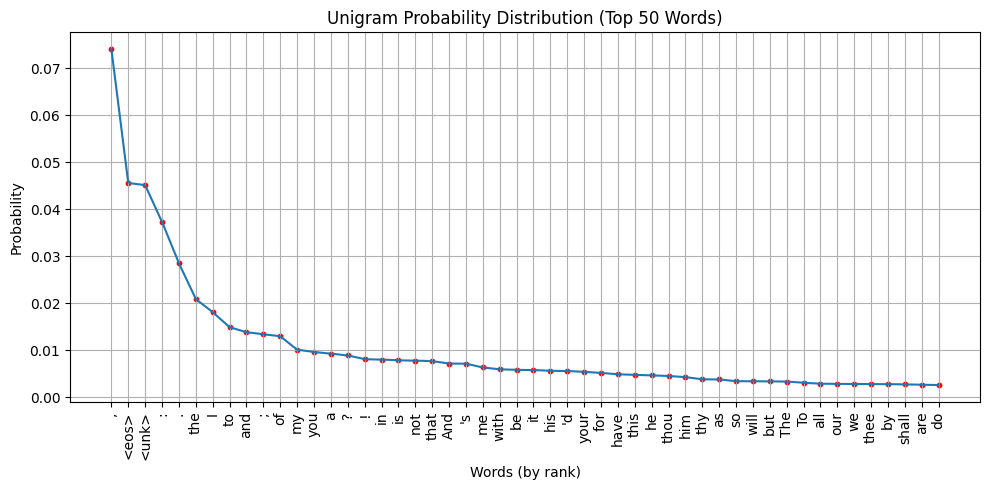

In [ ]:
train_data_wth_unks = switch_with_unk(train_data_processed, 3)
unigram_probs_wth_unks = compute_unigram_probabilities(train_data_wth_unks)
plot_unigram_distribution(unigram_probs_wth_unks , top_k=50)

In [ ]:
#TO-FILL section

def eval_likelihood_word_unigram_unk(data: List[str], unigram_probs_wth_unks: Dict[str, float]) -> Tuple[float, float]:
    """
    Evaluates the average_log_likelihood and perplexity of a word-level unigram language model.
    Unseen words are mapped to the <unk> token.

    Args:
    - data: List[str] —  sentences
    - unigram_probs_wth_unks: Dict[str, float] — Probabilities including <unk>

    Returns:
    -  Tuple of (average_log_likelihood, perplexity)
    """
    total_log_likelihood = 0.0
    total_words = 0

    for sentence in data:
        words = sentence.split()
        for word in words:
            # Map unseen words to <unk>
            word_to_evaluate = word if word in unigram_probs_wth_unks else "<unk>"
            total_log_likelihood += math.log(unigram_probs_wth_unks[word_to_evaluate])
            total_words += 1

    avg_log_likelihood = total_log_likelihood / total_words
    perplexity = math.exp(-avg_log_likelihood)

    return avg_log_likelihood, perplexity

In [ ]:
train_likelihood,train_ppl = eval_likelihood_word_unigram_unk(train_data_wth_unks, unigram_probs_wth_unks)
print(f"Train Perplexity: {train_ppl},Train likelihood: {train_likelihood}")
dev_likelihood,dev_ppl = eval_likelihood_word_unigram_unk(dev_data_processed, unigram_probs_wth_unks)
print(f"dev Perplexity: {dev_ppl},dev likelihood: {dev_likelihood}")

Train Perplexity: 384.0815655120125,Train likelihood: -5.9508549402194095
dev Perplexity: 282.0959070802668,dev likelihood: -5.642247109147883


### Section 1.4: Sampling from Unigram Language Model

Now that we have trained and evaluated our unigram language model, let's generate text from it!

**How text generation works:**
To generate text from an N-gram language model, we:
1. Start with some prefix words: $w_1, w_2, \ldots, w_n$
2. Sample the next word from the probability distribution based on previous words:
  $$w_{n+1} \sim P(w_{n+1} | w_{1}, \ldots, w_{n})$$

**Special case for unigram models:**
Since unigram models treat all words as independent (no context matters), the probability simplifies to:
$$w_{n+1} \sim P(w_{n+1})$$

This means each new word is sampled based only on how frequently it appears in the training data, regardless of what words came before it.

In [ ]:
#TO-FILL section

def generate_unigram_sample(unigram_probs: Dict[str, float], max_words: int, prefix: str = "") -> str:
    """
  Samples sequence of words from a unigram language model.
  Terminate sampling when either max_words is reached or when <eos> token is sampled.

  Args:
   - unigram_probs: Dict[str, float], a dictionary mapping words to their unigram probabilities
   - max_words: int, the number of words to sample
   - prefix: str, a prefix to start the sampling from. Can have multiple words separated by spaces.

  Returns:
   - str: sampled text i.e. string of sampled words separated by spaces along with the prefix

  # Note: Please use np.random.choice to sample from the unigram_probs dictionary.
   """

    words = list(unigram_probs.keys())
    probabilities = list(unigram_probs.values())
    sampled_words = prefix.split() if prefix else []

    for _ in range(max_words):
        next_word = np.random.choice(words, p=probabilities)
        sampled_words.append(next_word)
        if next_word == "<eos>":
            break

    return " ".join(sampled_words)

In [ ]:
def test_sampling():

    np.random.seed(0)
    sampled_string = generate_unigram_sample(unigram_probs_wth_unks, 10, "The king")
    print("Running Test Case 1: Check if the sampled string starts with the prefix")
    evaluate_test_case(None, sampled_string.startswith("The king"), True, output_str="Sampled string starts with the prefix")

    print("Running Test Case 2: Check if the sampled string has either 10 generated words or ends with <eos> token")
    print(f"Generated string: {sampled_string}")
    print(f"Number of generated words: {len(sampled_string.split()) - 2}")
    print(f"Does the generated string end with <eos> token: {'<eos>' in sampled_string}")
    if len(sampled_string.split()) - 2 == 10 or (
        len(sampled_string.split()) - 2 < 10 and "<eos>" in sampled_string
    ):
        print("Test passed! :)")
    else:
        print("Test failed! :(")
    print("\n" + "="*50 + "\n")

    print("Running Test Case 3: Check if the probability of generating <unk> token is correct")

    sampled_strings = [
        generate_unigram_sample(unigram_probs_wth_unks, 1, "")
        for _ in range(1000)
    ]
    sampled_string = " ".join(sampled_strings)
    num_unks = sampled_string.count("<unk>")
    unk_gen_prob = num_unks / len(sampled_string.split())
    evaluate_test_case(None, unk_gen_prob, unigram_probs_wth_unks["<unk>"], output_str="Probability of generating <unk> token", atol=1e-2)


In [ ]:

test_sampling()

Running Test Case 1: Check if the sampled string starts with the prefix
Sampled string starts with the prefix:
 True
Expected Sampled string starts with the prefix:
 True
Test case passed! :)


Running Test Case 2: Check if the sampled string has either 10 generated words or ends with <eos> token
Generated string: The king If thee For no that body of weeping drunk it
Number of generated words: 10
Does the generated string end with <eos> token: False
Test passed! :)


Running Test Case 3: Check if the probability of generating <unk> token is correct
Probability of generating <unk> token:
 0.051
Expected Probability of generating <unk> token:
 0.045185342597383396
Test case passed! :)




Lets sample! The unigram model generates text that lacks coherence since it ignores context and simply samples the most frequent tokens. Next, we'll build context-aware language models that consider preceding words when predicting the next token.

In [ ]:
for _ in range(5):
    sampled_string = generate_unigram_sample(unigram_probs_wth_unks, 10)
    print(sampled_string)

where , know this : if in <unk> do How
<unk> by To OF brow God in <eos>
Shepherd . I , KING aspiring Than our <unk> <unk>
. country . the yet high : that thus Do
I GAUNT <unk> : I <unk> willing <unk> the She


**Observation check**

**Expected Results:**
You should notice that the generated text doesn't make much sense! This is completely normal and expected.

**Why does this happen?**
Unigram models have a major limitation: they ignore context entirely. Since each word is sampled independently based only on its frequency in the training data, the model tends to just pick common words without considering whether they fit together meaningfully.

**What's next:**
We'll now build more sophisticated language models that consider context when predicting the next word. These N-gram models (bigram, trigram, etc.) will produce much more coherent text by accounting for the preceding words, though each model type considers different amounts of context.

## Section 2: N(>1)-Gram Word-Level Language Models

Implement N-gram language models that use surrounding text context. Unlike unigram models, N-gram models condition each token on the previous N-1 tokens:

$P(w_1, w_2, \cdots, w_n) = \prod_{k=1}^{n}P(w_k \mid w_{k-N+1}, \cdots, w_{k-1})$

For a bigram model (N=2):
$P(w_1, w_2, \cdots, w_n) = \prod_{k=1}^{n}P(w_k \mid w_{k-1})$

In [ ]:
# Before we start, training data to be the one with <unk> tokens and dev data to be the one with <eos> tokens in the end
train_data = train_data_wth_unks
dev_data = dev_data_processed

### Section 2.1: Text Processing

**Handling Sequence Boundaries:**

The N-gram formula $P(w_1, w_2, \ldots, w_n) = \prod_{k=1}^{n}P(w_k \mid w_{k-1})$ presents a boundary condition problem.

**The problem:**
- When $k = 1$, we get $P(w_1 | w_0)$ where $w_0$ does not exist
- For trigram models, we encounter terms like $P(w_1 | w_{-1}, w_0)$ and $P(w_2 | w_0, w_1)$ that reference non-existent words

**The solution:**
Add $N-1$ start-of-sequence tokens `<sos>` to the beginning of each sequence.

**Example:**
- Original sequence: "To be or not to be"
- For bigrams: "`<sos>` To be or not to be"
- For trigrams: "`<sos> <sos>` To be or not to be"

This ensures every word has sufficient context for N-gram probability calculations.


In [ ]:
#TO-FILL section
def process_Ngram(sents: List[str], N: int = 2) -> List[str]:
    """
    Adds N-1 <sos> tokens to the start of every sentence.

    Parameters:
        - sents: List of input sentences
        - N: N-gram size

    Returns:
        - List of processed sentences with <sos> prepended
    """
    processed_sents = []
    sos_tokens = " ".join(["<sos>"] * (N - 1))
    for sent in sents:
        if N > 1:
            processed_sents.append(f"{sos_tokens} {sent}")
        else:
            processed_sents.append(sent)
    return processed_sents

In [ ]:
# Sample test cases

def test_process_text_for_Ngram():

    sents = ["Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice .",
    "At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs .",
    "The world was so recent that many things lacked names, and in order to indicate them it was necessary to point ." ]

    print("Running Sample Test Case 1 with N=1")
    unigram_processed_text = process_Ngram(sents, 1)
    excepted_output = [
        "Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice .",
        "At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs .",
        "The world was so recent that many things lacked names, and in order to indicate them it was necessary to point ."
    ]
    evaluate_test_case(sents, unigram_processed_text, excepted_output)

    print("Running Sample Test Case 2 with N=2")
    bigram_processed_text = process_Ngram(sents, 2)
    excepted_output = [
        "<sos> Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice .",
        "<sos> At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs .",
        "<sos> The world was so recent that many things lacked names, and in order to indicate them it was necessary to point ."
    ]
    evaluate_test_case(sents, bigram_processed_text, excepted_output)

    print("Running Sample Test Case 3 with N=3")
    trigram_processed_text = process_Ngram(sents, 3)
    excepted_output = [
        "<sos> <sos> Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice .",
        "<sos> <sos> At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs .",
        "<sos> <sos> The world was so recent that many things lacked names, and in order to indicate them it was necessary to point ."
    ]
    evaluate_test_case(sents, trigram_processed_text, excepted_output)

    print("Running Sample Test Case 4 with N=4")
    fourgram_processed_text = process_Ngram(sents, 4)
    excepted_output = [
        "<sos> <sos> <sos> Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice .",
        "<sos> <sos> <sos> At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs .",
        "<sos> <sos> <sos> The world was so recent that many things lacked names, and in order to indicate them it was necessary to point ."
    ]
    evaluate_test_case(sents, fourgram_processed_text, excepted_output)



In [ ]:
test_process_text_for_Ngram()

Running Sample Test Case 1 with N=1
Input:
 ['Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice .', 'At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs .', 'The world was so recent that many things lacked names, and in order to indicate them it was necessary to point .']
Output:
 ['Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice .', 'At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs .', 'The world was so recent that many things lacked names, and in order to indicate them it was necessary 

# N-gram Language Model Implementation

## Overview

Implement an N-gram language model by estimating conditional distributions:

$P(w_n \mid w_{n-N-1}, \cdots, w_{n-1}) = \frac{C(w_{n-N-1} \cdots w_{n-1} w_{n})}{C(w_{n-N-1} \cdots w_{n-1})}$

where $C(\cdot)$ represents n-gram counts from the corpus.

## Requirements

Implement the `NGramLM` class with three functions:

1. **`fit`** - Compute n-gram counts from training data
2. **`evaluate`** - Evaluate model on test data  
3. **`sampling`** - Generate text using the language model


-Begin with bigram model, then generalize to n-grams


In [ ]:
#To-Fill section

class NGramLM:
  def __init__(self, N: int):
        self.N = N
        self.vocab = set()
        self.ngram_counts = defaultdict(Counter)
        self.context_counts = Counter()


  def fit(self, train_data: List[str]):
        """
        Trains an N-gram language model.
        Args:
            - train_data: List[str], sentences in the training data

        Note:
        1. Process sentences to add <sos> tokens
        2. Build vocabulary and count n-grams.Add <unk> to vocabulary
        3. Count N-grams and contexts

        """

        processed_data = process_Ngram(train_data, self.N)
        all_words = " ".join(processed_data).split()
        self.vocab = set(all_words)

        for sentence in processed_data:
            words = sentence.split()
            for i in range(len(words) - self.N + 1):
                ngram = tuple(words[i : i + self.N])
                context = tuple(words[i : i + self.N - 1])
                self.ngram_counts[context][ngram[-1]] += 1
                self.context_counts[context] += 1




  def evaluate(self, data: List[str]) -> float:
        """
        Evaluates the perplexity of the N-gram language model on the eval set.
        Input:
            - data: List[str], the evaluation text
        Output:
            - float, the perplexity of the model on the evaluation set
        For words that are not in the vocabulary, replace them with the <unk> token.
        """
        processed_data = process_Ngram(data, self.N)
        total_log_likelihood = 0.0
        total_words = 0

        for sentence in processed_data:
            words = sentence.split()
            for i in range(self.N - 1, len(words)):
                context = tuple(words[i - self.N + 1 : i])
                word = words[i]

                if word not in self.vocab:
                    word = "<unk>"

                if context not in self.context_counts or word not in self.ngram_counts[context]:
                    return (-math.inf, math.inf)

                probability = self.ngram_counts[context][word] / self.context_counts[context]
                total_log_likelihood += math.log(probability)
                total_words += 1

        avg_log_likelihood = total_log_likelihood / total_words
        perplexity = math.exp(-avg_log_likelihood)

        return avg_log_likelihood, perplexity


  def sampling(self, prefix: str = "<sos>", max_words: int = 100) -> str:
        """
        Samples text from the N-gram language model.
        Terminate sampling when either max_words is reached or when <eos> token is sampled.
        Args:
            - prefix: str, the prefix to start the sampling from. Can also be multiple words separated by spaces.
            - max_words: int, the maximum number of words to sample
        Returns:
            - str, the sampled text
        Note: Please use np.random.choice for sampling next words
        """
        sampled_words = prefix.split()

        # Add necessary <sos> tokens to the beginning of the prefix
        if self.N > 1:
            needed_sos = self.N - 1 - len(sampled_words)
            if needed_sos > 0:
                sampled_words = ["<sos>"] * needed_sos + sampled_words

        generated_words = []
        # Start generating after the prefix
        for _ in range(max_words):
            context = tuple(sampled_words[-(self.N - 1):])
            next_word_counts = self.ngram_counts.get(context, None)

            if not next_word_counts:
                # If context not seen, sample from unigram distribution (or <unk>)
                # For simplicity here, we'll break or sample <unk>
                if "<unk>" in self.vocab:
                  next_word = "<unk>"
                else:
                  break # Cannot sample if no context and no unk

            else:
                words = list(next_word_counts.keys())
                probabilities = list(next_word_counts.values())
                total_count = sum(probabilities)
                probabilities = [p / total_count for p in probabilities]
                next_word = np.random.choice(words, p=probabilities)


            sampled_words.append(next_word)
            generated_words.append(next_word) # Keep track of only generated words

            if next_word == "<eos>":
                break

        # Return the original prefix followed by the generated words
        return prefix + " " + " ".join(generated_words)

**Sanity Check:**
Verify that your N-gram implementation works correctly by setting N=1 and confirming it produces the same perplexities as your unigram model from earlier exercises.

In [ ]:
unigram_lm = NGramLM(1)
unigram_lm.fit(train_data)

train_ll,train_ppl = unigram_lm.evaluate(train_data)
dev_ll,dev_ppl = unigram_lm.evaluate(dev_data)
print(f" Unigram model : Train Perplexity {train_ppl}, Train likelihood {train_ll}")
print(f" Unigram model : dev Perplexity {dev_ppl}, dev likelihood {dev_ll}")

train_ll_old,train_ppl = eval_likelihood_word_unigram_unk(train_data, unigram_probs_wth_unks)
dev_ll_old,dev_ppl = eval_likelihood_word_unigram_unk(dev_data, unigram_probs_wth_unks)

print(f" Unigram model(earlier) : Train Perplexity {train_ppl}, Train loglikelihood {train_ll_old}")
print(f" Unigram model (earlier): dev Perplexity {dev_ppl}, dev loglikelihood {dev_ll_old}")

if np.allclose(train_ll, train_ll_old, atol = 1e-4) and np.allclose(dev_ll, dev_ll_old, atol = 1e-4):
    print("Unigram model perplexities match! :)")

else:
    print("Unigram model perplexities do not match! :(")

 Unigram model : Train Perplexity 384.0815655120125, Train likelihood -5.9508549402194095
 Unigram model : dev Perplexity 282.0959070802668, dev likelihood -5.642247109147883
 Unigram model(earlier) : Train Perplexity 384.0815655120125, Train loglikelihood -5.9508549402194095
 Unigram model (earlier): dev Perplexity 282.0959070802668, dev loglikelihood -5.642247109147883
Unigram model perplexities match! :)


Lets do it for BIGRAM!!!

In [ ]:
bigram_lm = NGramLM(2)
bigram_lm.fit(train_data)
train_ll,train_ppl = bigram_lm.evaluate(train_data)

dev_ll,dev_ppl = bigram_lm.evaluate(dev_data)
print(f" bigram model : Train Perplexity {train_ppl}, Train loglikelihood {train_ll}")
print(f" bigram model : dev Perplexity {dev_ppl}, dev loglikelihood {dev_ll}")

 bigram model : Train Perplexity 42.128332262041745, Train loglikelihood -3.7407204896873822
 bigram model : dev Perplexity inf, dev loglikelihood -inf


**Observation check**
You should observe a train perplexity of atmost 43 and a dev perplexity of infinity. We will address the infinite dev perplexity issue in upcoming sections. ANYthing beyond 43 requires double check your code.




In [ ]:
trigram_lm = NGramLM(3)
trigram_lm.fit(train_data)
train_ll,train_ppl = trigram_lm.evaluate(train_data)

dev_ll,dev_ppl = trigram_lm.evaluate(dev_data)
print(f" trigram model : Train Perplexity {train_ppl}, Train loglikelihood {train_ll}")
print(f" trigram model : dev Perplexity {dev_ppl}, dev loglikelihood {dev_ll}")



fourgram_lm = NGramLM(4)
fourgram_lm.fit(train_data)
train_ll,train_ppl = fourgram_lm.evaluate(train_data)

dev_ll,dev_ppl = bigram_lm.evaluate(dev_data)
print(f" fourgram model : Train Perplexity {train_ppl}, Train loglikelihood {train_ll}")
print(f" fourgram model : dev Perplexity {dev_ppl}, dev loglikelihood {dev_ll}")



fivegram_lm = NGramLM(5)
fivegram_lm.fit(train_data)
train_ll,train_ppl = fivegram_lm.evaluate(train_data)

dev_ll,dev_ppl = fivegram_lm.evaluate(dev_data)
print(f" fivegram model : Train Perplexity {train_ppl}, Train loglikelihood {train_ll}")
print(f" fivegram model : dev Perplexity {dev_ppl}, dev loglikelihood {dev_ll}")

 trigram model : Train Perplexity 5.939635966646537, Train loglikelihood -1.781647846420206
 trigram model : dev Perplexity inf, dev loglikelihood -inf
 fourgram model : Train Perplexity 2.0705701088539454, Train loglikelihood -0.7278239842628427
 fourgram model : dev Perplexity inf, dev loglikelihood -inf
 fivegram model : Train Perplexity 1.595255728780846, Train loglikelihood -0.4670340549091241
 fivegram model : dev Perplexity inf, dev loglikelihood -inf


You should see train perplexities atmost 6, 3, and 2 for trigram, 4-gram, and 5-gram LMs. For dev data the dev perplexity should be infinity for all the three.

 beyond that require correction in the code

In [ ]:
def test_sample_text_ngram():

    print("Testing for Trigram model")

    random.seed(42)
    np.random.seed(42)
    trigram_lm = NGramLM(3)
    trigram_lm.fit(train_data)
    sampled_text = trigram_lm.sampling("<sos> <sos>", max_words=50)

    print("Test Case 1: Check if the sampled text starts with <sos> <sos>")
    evaluate_test_case(None, sampled_text.startswith("<sos> <sos>"), True, output_str="Sampled text starts with <sos> <sos>")

    print("Test Case 2: Check if the number of generated words is either 50 or less than 50 and ends with <eos>")
    print(f"Generated text: {sampled_text}")
    print(f"Number of generated words: {len(sampled_text.split()) - 2}")
    print(f"Does the generated text end with <eos>: {'<eos>' in sampled_text}")
    if len(sampled_text.split()) - 2 == 50 or (
        len(sampled_text.split()) - 2 < 50 and "<eos>" in sampled_text
    ):
        print("Test passed! :)")
    else:
        print("Test failed! :(")

    print("\n" + "="*50 + "\n")

    print("Test Case 3: Check if the probability of generating II is greater than III when prefix is KING RICHARD")
    sampled_texts = [
        trigram_lm.sampling("KING RICHARD", max_words=1) for _ in range(10000)
    ]
    sampled_text = " ".join(sampled_texts)
    num_richard_2s = [
        text.split("KING RICHARD")[1].strip() == "II" for text in sampled_texts
    ].count(True)
    num_richard_3s = [
        text.split("KING RICHARD")[1].strip() == "III" for text in sampled_texts
    ].count(True)

    gen_prob_richard_2 = num_richard_2s / len(sampled_texts)
    gen_prob_richard_3 = num_richard_3s / len(sampled_texts)

    print(f"Probability of generating Richard II: {gen_prob_richard_2}")
    print(f"Probability of generating Richard III: {gen_prob_richard_3}")
    if gen_prob_richard_2 < gen_prob_richard_3:
        print("Test passed! :)")
    else:
        print("Test failed! :(")

    print("\n" + "="*50 + "\n")

    print("Test Case 4: Check if the probability of generating II given KING RICHARD are close to the expected values")
    evaluate_test_case("King Richard II", gen_prob_richard_2, 0.4229, output_str="Probability of generating Richard II", atol=1e-2)

    print("Test Case 5: Check if the probability of generating III given KING RICHARD are close to the expected values")
    evaluate_test_case("King Richard III", gen_prob_richard_3, 0.5771, output_str="Probability of generating Richard III", atol=1e-2)

    print("Testing for 4-gram model")
    random.seed(42)
    np.random.seed(42)
    fourgram_lm = NGramLM(4)
    fourgram_lm.fit(train_data_wth_unks)
    sampled_text = fourgram_lm.sampling("<sos> <sos>", max_words=50)

    sampled_text = fourgram_lm.sampling("<sos> <sos> <sos>", max_words=50)

    print("Test Case 6: Check if the sampled text starts with <sos> <sos> <sos>")
    evaluate_test_case(None, sampled_text.startswith("<sos> <sos> <sos>"), True, output_str="Sampled text starts with <sos> <sos> <sos>")

    print("Test Case 7: Check if the number of generated words is either 50 or less than 50 and ends with <eos>")
    print(f"Generated text: {sampled_text}")
    print(f"Number of generated words: {len(sampled_text.split()) - 3}")
    print(f"Does the generated text end with <eos>: {'<eos>' in sampled_text}")
    if len(sampled_text.split()) - 3 == 50 or (
        len(sampled_text.split()) - 3 < 50 and "<eos>" in sampled_text
    ):
        print("Test passed! :)")

    else:
        print("Test failed! :(")

    print("\n" + "="*50 + "\n")

    print("Test Case 8: Check if the probability of generating II is greater than III when prefix is <sos> KING RICHARD")
    sampled_texts = [
        fourgram_lm.sampling("<sos> <sos> KING RICHARD", max_words=1) for _ in range(10000)
    ]
    sampled_text = " ".join(sampled_texts)
    num_richard_2s = [
        text.split("<sos> <sos> KING RICHARD")[1].strip() == "II" for text in sampled_texts
    ].count(True)

    num_richard_3s = [
        text.split("<sos> <sos> KING RICHARD")[1].strip() == "III" for text in sampled_texts
    ].count(True)

    gen_prob_rich2 = num_richard_2s / len(sampled_texts)
    gen_prob_rich3 = num_richard_3s / len(sampled_texts)

    print(f"Probability of generating Richard II: {gen_prob_rich2}")
    print(f"Probability of generating Richard III: {gen_prob_rich3}")
    if gen_prob_rich2 < gen_prob_rich3:
        print("Test passed! :)")
    else:
        print("Test failed! :(")

    print("\n" + "="*50 + "\n")

    print("Test Case 9: Check if the probability of generating II given <sos> KING RICHARD are close to the expected values")
    evaluate_test_case("<sos> King Richard II", gen_prob_rich2, 0.4229, output_str="Probability of generating Richard II", atol=1e-2)

    print("Test Case 10: Check if the probability of generating III given <sos> KING RICHARD are close to the expected values")
    evaluate_test_case("<sos> King Richard III", gen_prob_rich3, 0.5771, output_str="Probability of generating Richard III", atol=1e-2)

test_sample_text_ngram()

Testing for Trigram model
Test Case 1: Check if the sampled text starts with <sos> <sos>
Sampled text starts with <sos> <sos>:
 True
Expected Sampled text starts with <sos> <sos>:
 True
Test case passed! :)


Test Case 2: Check if the number of generated words is either 50 or less than 50 and ends with <eos>
Generated text: <sos> <sos> Please your honour , state and seat is up on high ; Whilst you have been i ' the part I had a Harry , Harry , <unk> to you both ! <eos>
Number of generated words: 33
Does the generated text end with <eos>: True
Test passed! :)


Test Case 3: Check if the probability of generating II is greater than III when prefix is KING RICHARD
Probability of generating Richard II: 0.4052
Probability of generating Richard III: 0.5948
Test passed! :)


Test Case 4: Check if the probability of generating II given KING RICHARD are close to the expected values
Input:
 King Richard II
Probability of generating Richard II:
 0.4052
Expected Probability of generating Richard I

In [ ]:
np.random.seed(42)
print("Generations from Trigram model")
for _ in range(20):
    sampled_text = trigram_lm.sampling("<sos> <sos> KING", max_words=50)
    print(sampled_text)

Generations from Trigram model
<sos> <sos> KING RICHARD II : I am known to go . <eos>
<sos> <sos> KING EDWARD IV : Is it not amiss ; I will to sanctuary . <eos>
<sos> <sos> KING RICHARD II : Where <unk> , behold 's : there she lost a brace . <eos>
<sos> <sos> KING EDWARD IV : Brave warriors , Clifford , take heed , for Lancaster ! <eos>
<sos> <sos> KING HENRY VI : My lord , the fool was that of common soldiers slain . <eos>
<sos> <sos> KING EDWARD IV : Go thither ; For this will teach thee how to curse mine enemies ! <eos>
<sos> <sos> KING RICHARD III : Say no more hear from you The apprehension of the news abroad ? <eos>
<sos> <sos> KING RICHARD II : We have made fault I ' shall poison , go in your city is <unk> 'd out an act of parliament be repeal 'd , Nay , now at my injustice . <eos>
<sos> <sos> KING RICHARD III : O Marcius , Attend upon Cominius to these arms , and did scorn an humble tear ; And therefore , not for your country 's foes , to <unk> and <unk> 'd : say it is . <eos>


**Observation check**
You should see that the generation quality is now better.



## Problem
N-gram models assign zero probability to unseen N-grams in test data, causing infinite perplexity.

## Solution: Add-k Smoothing
Add-k smoothing redistributes probability mass from frequent to unseen events:

$$P_{\text{Add-k}}(w_n \mid w_{n-1}) = \frac{C(w_{n-1}w_n) + k}{C(w_{n-1}) + kV}$$

where:
- $k$ is the smoothing parameter (k=1 for Laplace/Add-one smoothing)
- $V$ is the vocabulary size
- $C(\cdot)$ represents n-gram counts

This ensures no zero probabilities while preserving relative frequency patterns.


Implement the `Ksmoothing` class following the same structure as `NGramLM`, but modify the conditional probability calculations to include Add-k smoothing.

In [ ]:
#TO-FILL section

class Ksmoothing(NGramLM):
    def __init__(self, N: int, k: float = 1):
        super().__init__(N)
        self.k = k
        self.V = 0 # Vocabulary size will be set during fit

    def fit(self, train_data: List[str]):
        """
        Trains an N-gram language model with Add-k smoothing.

        Inputs:
            - train_data: str, sentences in the training data

        """

        processed_data = process_Ngram(train_data, self.N)
        all_words = " ".join(processed_data).split()
        self.vocab = set(all_words)
        self.V = len(self.vocab)

        for sentence in processed_data:
            words = sentence.split()
            for i in range(len(words) - self.N + 1):
                ngram = tuple(words[i : i + self.N])
                context = tuple(words[i : i + self.N - 1])
                self.ngram_counts[context][ngram[-1]] += 1
                self.context_counts[context] += 1

    def eval_perplexity(self, eval_data: List[str]) -> float:
        """
        Evaluates the perplexity of the N-gram language model with Add-k smoothing on the eval set.

        Input:
            - eval_data: List[str], the evaluation text

        Output:
            - float, the perplexity of the model on the evaluation set

        Note : For tokens that are not in the vocabulary, replace them with the <unk> token.

        """
        processed_data = process_Ngram(eval_data, self.N)
        total_log_likelihood = 0.0
        total_words = 0

        for sentence in processed_data:
            words = sentence.split()
            for i in range(self.N - 1, len(words)):
                context = tuple(words[i - self.N + 1 : i])
                word = words[i]

                if word not in self.vocab:
                    word = "<unk>"

                # Calculate smoothed probability
                ngram_count = self.ngram_counts.get(context, {}).get(word, 0)
                context_count = self.context_counts.get(context, 0)

                smoothed_probability = (ngram_count + self.k) / (context_count + self.k * self.V)

                total_log_likelihood += math.log(smoothed_probability)
                total_words += 1

        avg_log_likelihood = total_log_likelihood / total_words
        perplexity = math.exp(-avg_log_likelihood)

        return perplexity


    def sample_text(self, prefix: str = "<sos>", max_words: int = 100) -> str:
      """
        Samples text from the N-gram language model.

        Args:
            - prefix: str, the prefix to start the sampling from. Can also be multiple words separated by spaces.
            - max_words: int, the maximum number of words to sample

        Return:
            - str, the sampled text

        Note: Please use np.random.choice for sampling next words
      """
      sampled_words = prefix.split()

      # Add necessary <sos> tokens to the beginning of the prefix
      if self.N > 1:
          needed_sos = self.N - 1 - len(sampled_words)
          if needed_sos > 0:
              sampled_words = ["<sos>"] * needed_sos + sampled_words


      generated_words = []
      # Start generating after the prefix
      for _ in range(max_words):
          context = tuple(sampled_words[-(self.N - 1):])

          # Get all possible next words from the vocabulary
          possible_next_words = list(self.vocab)
          probabilities = []
          context_count = self.context_counts.get(context, 0)

          for next_word in possible_next_words:
              ngram_count = self.ngram_counts.get(context, {}).get(next_word, 0)
              smoothed_probability = (ngram_count + self.k) / (context_count + self.k * self.V)
              probabilities.append(smoothed_probability)

          # Normalize probabilities
          total_prob = sum(probabilities)
          probabilities = [p / total_prob for p in probabilities]


          next_word = np.random.choice(possible_next_words, p=probabilities)

          sampled_words.append(next_word)
          generated_words.append(next_word) # Keep track of only generated words

          if next_word == "<eos>":
              break

      # Remove leading <sos> tokens for the final output string
      if self.N > 1:
        while sampled_words and sampled_words[0] == "<sos>":
          sampled_words.pop(0)


      return " ".join(sampled_words)

In [ ]:
bigram_lm = Ksmoothing(2, k = 0.01)
bigram_lm.fit(train_data)
train_ppl = bigram_lm.eval_perplexity(train_data)
print(f"Train Perplexity: {train_ppl}")
dev_ppl = bigram_lm.eval_perplexity(dev_data)
print(f"Dev Perplexity: {dev_ppl}")

Train Perplexity: 60.78600290093535
Dev Perplexity: 204.60665290389517


**Observation check**
Notice that the development set perplexity is no longer ∞! This improvement comes at a cost: the training perplexity increases. This trade-off occurs because smoothing redistributes probability mass from observed N-grams in the training data to unseen N-grams, reducing the model's fit to training data while improving generalization to new text.

You should get a train perplexity atmost 61 and dev perplexity atmost 149. beyond that require correction in the code

**Test cases-I**

In [ ]:
def test_sample_text_bigram_laplace_model():
    bigram_lm = Ksmoothing(2, k = 1)
    bigram_lm.fit(train_data)

    random.seed(42)
    np.random.seed(42)
    sampled_text = bigram_lm.sample_text("<sos>", max_words=50)

    print("Test Case 1: Check if the sampled text starts with <sos>")
    evaluate_test_case(
        None,
        sampled_text.startswith("<sos>"),
        True,
        output_str="Sampled text starts with <sos>",
    )

    print(
        "Test Case 2: Check if the number of generated words is either 50 or less than 50 and ends with <eos>"
    )
    print(f"Generated text: {sampled_text}")
    print(f"Number of generated words: {len(sampled_text.split()) - 1}")
    print(f"Does the generated text end with <eos>: {'<eos>' in sampled_text}")
    if len(sampled_text.split()) - 1 == 50 or (
        len(sampled_text.split()) < 50 and "<eos>" in sampled_text
    ):
        print("Test passed! :)")
    else:
        print("Test failed! :(")

    print("\n" + "=" * 50 + "\n")

    print(
        "Test Case 3: Check if the probability of generating II is greater than III when prefix is RICHARD"
    )
    sampled_texts = [
        bigram_lm.sample_text("RICHARD", max_words=1) for _ in range(1000)
    ]
    sampled_text = " ".join(sampled_texts)
    num_richard_2s = [
        text.split("RICHARD")[1].strip() == "II" for text in sampled_texts
    ].count(True)
    num_richard_3s = [
        text.split("RICHARD")[1].strip() == "III" for text in sampled_texts
    ].count(True)
    gen_prob_richard_2 = num_richard_2s / len(sampled_texts)
    gen_prob_richard_3 = num_richard_3s / len(sampled_texts)

    print(f"Probability of generating Richard II: {gen_prob_richard_2}")
    print(f"Probability of generating Richard III: {gen_prob_richard_3}")
    if gen_prob_richard_2 < gen_prob_richard_3:
        print("Test passed! :)")
    else:
        print("Test failed! :(")

    print("\n" + "=" * 50 + "\n")


    print(
        "Test Case 4: Check if the probability of generating III given RICHARD are close to the expected values"
    )
    evaluate_test_case(
        "Richard III",
        gen_prob_richard_3,
        0.034,
        output_str="Probability of generating Richard III",
        atol=1e-3,
    )

test_sample_text_bigram_laplace_model()

Test Case 1: Check if the sampled text starts with <sos>
Sampled text starts with <sos>:
 False
Expected Sampled text starts with <sos>:
 True
Test case failed! :(


Test Case 2: Check if the number of generated words is either 50 or less than 50 and ends with <eos>
Generated text: YORK counsels box gotten wholesome its coming granted Whiles nothing imposition frail Castle holp beasts friend turned beget humbly removed disease speak'st powers got buckle Advance once succession green redemption necessity curses Become hang You black heaviness noble up Froth figure seen Wiltshire enemy preposterous senators groan sending received birth
Number of generated words: 49
Does the generated text end with <eos>: False
Test failed! :(


Test Case 3: Check if the probability of generating II is greater than III when prefix is RICHARD
Probability of generating Richard II: 0.024
Probability of generating Richard III: 0.021
Test failed! :(


Test Case 4: Check if the probability of generating III giv

In [ ]:
print("Generations from Trigram model")
trigram_lm = Ksmoothing(2, k = 0.01)
trigram_lm.fit(train_data)
for _ in range(20):
    sampled_text = trigram_lm.sample_text("<sos> <sos> KING", max_words=50)
    print(sampled_text)


Generations from Trigram model
KING RICHARD III farther allegiance 'shall royalties matter So fares twelve agony mock distress tire utterance tragic pale hard amen beshrew safer low . <eos>
KING kingly sings errand Thanks conceit trees mend tried Yield Art men <unk> Their shouts sweat Gloucester , she is my lord . <eos>
KING EDWARD IV : A plague Seal Scotland couple living reap jewel restraint haught fame lives disgraced ages virgin dreadful thou wilt thou once fathers , he has entertainment tenderness health ways Black Stand bite Beseech keep gods do not to nose tremble ? <eos>
KING HENRY BOLINGBROKE : Nay , come to tell him long James perforce prick everlasting hole enforce warlike Norfolk : come ; but a treacherous 'It PETER pleaseth doubt Full soon , <unk> time of my good fellow so <unk> , but four BUCKINGHAM : Pray venge preserve patricians bereft chances
KING RICHARD II : Whilst quickly will , for once jest Go thither kill trusty points moves northern Farewell enters Percy concer

**Test cases-II**

In [ ]:
def test_sample_text_ngram_laplace():
    print("Testing for Trigram model")

    random.seed(42)
    np.random.seed(42)
    trigram_lm = Ksmoothing(3)
    trigram_lm.fit(train_data)
    sampled_text = trigram_lm.sample_text("<sos> <sos>", max_words=50)

    print("Test Case 1: Check if the sampled text starts with <sos> <sos>")
    evaluate_test_case(
        None,
        sampled_text.startswith("<sos> <sos>"),
        True,
        output_str="Sampled text starts with <sos> <sos>",
    )

    print(
        "Test Case 2: Check if the number of generated words is either 50 or less than 50 and ends with <eos>"
    )
    print(f"Generated text: {sampled_text}")
    print(f"Number of generated words: {len(sampled_text.split()) - 2}")
    print(f"Does the generated text end with <eos>: {'<eos>' in sampled_text}")
    if len(sampled_text.split()) - 2 == 50 or (
        len(sampled_text.split()) - 2 < 50 and "<eos>" in sampled_text
    ):
        print("Test passed! :)")
    else:
        print("Test failed! :(")

    print("\n" + "=" * 50 + "\n")

    print(
        "Test Case 3: Check if the probability of generating II is less than III when prefix is KING RICHARD"
    )
    sampled_texts = [
        trigram_lm.sample_text("KING RICHARD", max_words=1) for _ in range(1000)
    ]
    sampled_text = " ".join(sampled_texts)
    num_richard_2s = [
        text.split("KING RICHARD")[1].strip() == "II" for text in sampled_texts
    ].count(True)
    num_richard_3s = [
        text.split("KING RICHARD")[1].strip() == "III" for text in sampled_texts
    ].count(True)

    gen_prob_richard_2 = num_richard_2s / len(sampled_texts)
    gen_prob_richard_3 = num_richard_3s / len(sampled_texts)

    print(f"Probability of generating Richard II: {gen_prob_richard_2}")
    print(f"Probability of generating Richard III: {gen_prob_richard_3}")
    if gen_prob_richard_2 < gen_prob_richard_3:
        print("Test passed! :)")
    else:
        print("Test failed! :(")

    print("\n" + "=" * 50 + "\n")


    print("Testing for 4-gram model")
    fourgram_lm = Ksmoothing(4)
    fourgram_lm.fit(train_data)
    sampled_text = fourgram_lm.sample_text("<sos> <sos> <sos>", max_words=50)

    print("Test Case 4: Check if the sampled text starts with <sos> <sos> <sos>")
    evaluate_test_case(
        None,
        sampled_text.startswith("<sos> <sos> <sos>"),
        True,
        output_str="Sampled text starts with <sos> <sos> <sos>",
    )

    print(
        "Test Case 5: Check if the number of generated words is either 50 or less than 50 and ends with <eos>"
    )
    print(f"Generated text: {sampled_text}")
    print(f"Number of generated words: {len(sampled_text.split()) - 3}")
    print(f"Does the generated text end with <eos>: {'<eos>' in sampled_text}")
    if len(sampled_text.split()) - 3 == 50 or (
        len(sampled_text.split()) - 3 < 50 and "<eos>" in sampled_text
    ):
        print("Test passed! :)")

    else:
        print("Test failed! :(")

    print("\n" + "=" * 50 + "\n")






test_sample_text_ngram_laplace()

Testing for Trigram model
Test Case 1: Check if the sampled text starts with <sos> <sos>
Sampled text starts with <sos> <sos>:
 False
Expected Sampled text starts with <sos> <sos>:
 True
Test case failed! :(


Test Case 2: Check if the number of generated words is either 50 or less than 50 and ends with <eos>
Generated text: YORK befall box most fliers fliers coming granted So bite trespass six Castle Christ beasts blasts False gracious might Through disease aloud Jerusalem got blunt senses blown seat wench hag deny goodly duteous hang You wicked while infringe English stem figure gust Wiltshire mischief avoided senators valour boots received rotten
Number of generated words: 48
Does the generated text end with <eos>: False
Test failed! :(


Test Case 3: Check if the probability of generating II is less than III when prefix is KING RICHARD
Probability of generating Richard II: 0.019
Probability of generating Richard III: 0.023
Test passed! :)


Testing for 4-gram model
Test Case 4: Che